In [1]:
import math
from itertools import product
import numpy as np
import scipy.sparse as sparse
import scipy.stats as stats
import matplotlib.pyplot as plt

# the seed used to produce reproducible results
seeds = [1031120431,875640033,274554418,1894466998,1966148588,346178454,1051313363,1785662044,399562627,1111614859]

# the number of spins
n = 20

In [2]:
def neighborhoodGraph(w, c):
    '''Find the neighborhood graph that is fully connected'''
    for i in range(n):
        for j in range(n):
            if w[i][j] == 0:
                c[i][j] = 0
    return c

def sprandsym(n, density):
    '''Generate a sparse random N*N symmetric matrix with density as stated'''
    rvs = stats.norm().rvs
    X = sparse.random(n, n, density=density, data_rvs=rvs)
    upper_X = sparse.triu(X) 
    result = upper_X + upper_X.T - sparse.diags(X.diagonal())
    return result

def cWithSigns(w):
    '''Just a quick aiding matrix to find sparse matrix with +/- beta on the links'''
    trial_graph = np.ones((n,n))
    neighbor_graph = neighborhoodGraph(w, trial_graph)
    for i in range(n):
        for j in range(n):
            if w[i][j] < 0:
                neighbor_graph[i][j] = -1
    return neighbor_graph

# Toggle between full and sparse Ising network
def sparseOrNot(not_sparse, beta, c1):
    '''
    Inputs:
        not_sparse: a binary variable taking True/False
        beta: a number
        c1: a number determining the density of the sparse matrix
    Returns:
        w: the n*n weight matrix
    '''
    if not_sparse == True:
        # when the considered matrix is not sparse
        J0 = 0
        J = beta
        w = np.random.normal(J0/n, J/math.sqrt(n), (n,n))
        #w = J0/n + (J/math.sqrt(n)) * np.random.randn(n, n)
        w = w - np.diag(np.diag(w))
        w = np.tril(w) + np.tril(w).T
        c = np.ones((n,n))
        c = neighborhoodGraph(w, c)
    else:
        k = c1 * n
        w = sprandsym(n, c1)
        w = w.A
        w = w - np.diag(np.diag(w))
        c = np.ones((n,n))
        c = neighborhoodGraph(w, c)
        c_with_signs = cWithSigns(w)
        w = beta * c_with_signs
        
    return w

In [3]:
def initialisation(N):   
    ''' Generates all spin configurations for initial condition'''
    spin_matrix = list(product([1, -1], repeat=N))
    return np.array(spin_matrix)

sa = initialisation(n)

def theta(beta):
    th = np.random.randn(n, 1) * beta
    return th


def exactIsing(sa, w, th):
    '''
    Returns:
        a tuple (p_ex, m_ex, chi_ex)
        p_ex: the probabilities of all 2^n configurations
        m_ex: exact mean values of spins
        chi_ex: exact connected correlations
    '''
    x = np.matmul(w, sa.T)
    Ea = 0.5*np.sum(sa*x.T, axis=1) + np.matmul(sa, th).reshape(-1)
    Ea_exp = np.exp(Ea)
    Z = np.sum(Ea_exp)
    
    # the probabilities of all 2^n configurations
    p_ex = (Ea_exp/Z).reshape(-1, 1)
    
    # exact mean value of spins
    m_ex = np.matmul(sa.T, p_ex)
    
    # exact connected correlations
    klad = np.matmul(p_ex, np.ones((1, n))) * sa
    chi_ex = np.matmul(sa.T, klad) - np.matmul(m_ex, m_ex.T)
    
    return (p_ex, m_ex, chi_ex)

In [4]:
class meanFieldApprox:
    def __init__(self, w, th):
        '''
        Inputs:
            w: the weight matrix
            th: the external field
        '''
        self.w = w
        self.th = th
          
    def update(self, eta, m):
        '''
        Inputs:
            eta: the smoothing constant
            m: the vector of expectation values of spin configurations
        Returns:
            a triple (m, n, chi)
            m: the updated vector of expectation values of spin configurations
            dm: the difference between old and new matrix m
        '''
        m_old = m
        stuff = np.matmul(self.w, m) + self.th
        m = eta*m + (1-eta)*np.tanh(stuff)
        dm = np.max(np.abs(m-m_old))
        return (m, dm)
    
    def train(self, eta, m):
        '''
        Returns:
            A triple (m, iter_num, chi)
            m: the final updated vector of expectation values of spin configurations
            iter_num: the number of iterations for convergence
            chi: the connected correlation
        '''
        iter_num = 0
        dm = 1
        epsilon = 10**(-13)
        m_prime = np.zeros((20, 1))
        
        while dm > epsilon:
            m = self.update(eta, m)[0]
            dm = self.update(eta, m)[1]
            iter_num += 1
            #print("Iteration: {}; dm: {}".format(n, dm))
        
        for i in range(20):
            m_prime[i] = np.divide(1, 1-m[i]**2)
        
        A = np.identity(20)*m_prime - self.w
        chi = np.linalg.inv(A)
    
        return (m, iter_num, chi)
        

In [5]:
class beliefProp:
    def __init__(self, w, th):
        '''
        Inputs:
            w: the weight matrix
            th: the external field
        '''
        self.w = w
        self.th = th
        
    def whatAreNotNeighboursBP(self, i):
        '''
        Returns:
            the list of all not Neighbours of the node i
        '''
        wi = self.w[i, :]
        non_neighbours = list(np.where(wi==0)[0])
        return non_neighbours
        
        
    def oneMessage(self, i, j, xj, a):
        '''
        Inputs:
            xj: the spin configuration at jth node taking -1 or 1
            a: the n*n matrix of the parameter if we write messages as an exponential distribution
        Returns:
            the value of the message along edge i-j or self-interaction
        '''
        #mij = 2*math.cosh(self.w[i][j]*xj + self.th[i] + np.sum(np.delete(a[:, i], [i, j])))
        nn = self.whatAreNotNeighboursBP(i)
        nn.append(j)
        mij = 2*math.cosh(self.w[i][j]*xj + self.th[i] + np.sum(np.delete(a[:, i], list(set(nn)))))
        return mij
    
    def mPos(self, a):
        m_pos = np.zeros((20, 20))
        indices = list(product([i for i in range(n)], repeat=2))
        for item in indices:
            i = item[0]
            j = item[1]
            if i==j:
                m_pos[i][j] = 1
            else:
                m_pos[i][j] = self.oneMessage(i, j, 1, a)

        return m_pos
    
    def mNeg(self, a):
        m_neg = np.zeros((20, 20))
        indices = list(product([i for i in range(n)], repeat=2))
        for item in indices:
            i = item[0]
            j = item[1]
            if i==j:
                m_neg[i][j] = 1
            else:
                m_neg[i][j] = self.oneMessage(i, j, -1, a)
                
        return m_neg
    
    def whatIsB(self, i, j, a):
        '''
        Returns:
            bij: the joint probability along the edge i-j after convergence
        '''
        two_spins = list(product([1, -1], repeat=2))
        spins = [1, -1]
        bij = []
        if i == j:
            for spin in spins:
                bij.append(np.exp(2*self.th[i]*spin))
            bij = np.array(bij).reshape(-1, 1)
            bij = bij/np.sum(bij)
        else:
            #ai = np.delete(a[:, i], [i, j])
            #aj = np.delete(a[:, j], [i, j])
            nn_i = self.whatAreNotNeighboursBP(i)
            nn_i.append(j)
            nn_j = self.whatAreNotNeighboursBP(j)
            nn_j.append(i) 
            ai = np.delete(a[:, i], list(set(nn_i)))
            aj = np.delete(a[:, j], list(set(nn_j)))
            for two_spin in two_spins:
                xi = two_spin[0]
                xj = two_spin[1]
                bij.append(np.exp(self.w[i][j]*xi*xj + self.th[i]*xi + self.th[j]*xj + np.sum(ai)*xi + np.sum(aj)*xj))
            bij = np.array(bij).reshape(-1, 1)
            bij = bij/np.sum(bij)
        return bij
            
    
    def train(self, eta, a):
        '''
        Inputs:
            eta: the smoothing constant
            a: the value for calculating the final matrix m
        Results:
            a quadruple (m, a, iter_num, chi)
            m: the matrix of expectation values of spins
            iter_num: the number of iterations for convergence
            chi: the connection correlation
        '''
        iter_num = 0
        da = 1
        epsilon = 10**(-13)
        while da>epsilon:
            a_old = a
            m_pos = self.mPos(a)
            m_neg = self.mNeg(a)
            a = eta*a + (1-eta)*0.5*np.log(np.divide(m_pos, m_neg))
            #a = 0.5*np.log(np.divide(m_pos, m_neg))
            da = np.max(np.abs(a-a_old))
            iter_num += 1
            #print('iter: {}; da: {}'.format(iter_num, da))
            
        b = np.sum(a, axis=0)
        b = np.reshape(b, (-1, 1))
        m = np.tanh(self.th+b)
        
        chi = np.zeros((n, n))
        for i in range(n):
            for j in range(n):
                if i == j:
                    chi[i][j] = np.sum(np.array([[1],[1]])*self.whatIsB(i,j,a))-m[i]*m[j]
                else:
                    chi[i][j] = np.sum(np.array([[1],[-1],[-1],[1]])*self.whatIsB(i,j,a))-m[i]*m[j]
        return (m, a, iter_num, chi)
        

In [6]:
def rmse(predictions, targets):
    return np.sqrt(((predictions - targets) ** 2).mean())

In [7]:
def Errors(seed_index, beta, iter_times):
    '''
    Returns:
        a list of tuples [(mean of rmse of mfa, std of rmse of mfa), (mean of rmse of bpa, std of rmse of bpa)]
    '''
    i = 0
    errors_mfa = []
    errors_bpa = []
    
    chi_errors_mfa = []
    chi_errors_bpa = []
    
    seed = seeds[seed_index]
    np.random.seed(seed)
    
    while i < iter_times:
        m = np.random.rand(n,1)
        a = np.random.rand(n, n)
        a = a - np.diag(np.diag(a))
        th = theta(beta)
        w = sparseOrNot(True, beta, 0)
        
        mfa = meanFieldApprox(w, th)
        mfa_results = mfa.train(0.5, m)
        m_mfa = mfa_results[0]
        chi_mfa = mfa_results[2]
        
        bpa = beliefProp(w, th)
        bpa_results = bpa.train(0.5, a)
        m_bpa = bpa_results[0]
        chi_bpa = bpa_results[3]
        
        ising_results = exactIsing(sa, w, th)
        m_ex = ising_results[1]
        chi_ex = ising_results[2]
        
        mfa_iter = mfa_results[1]
        bpa_iter = bpa_results[2]
        
        error_mfa = rmse(m_mfa, m_ex)
        error_bpa = rmse(m_bpa, m_ex)
        
        chi_error_mfa = rmse(chi_mfa, chi_ex)
        chi_error_bpa = rmse(chi_bpa, chi_ex)
        
        errors_mfa.append(error_mfa)
        errors_bpa.append(error_bpa)
        
        chi_errors_mfa.append(chi_error_mfa)
        chi_errors_bpa.append(chi_error_bpa)
        
        i += 1
    
    errors_mfa = np.array(errors_mfa)
    errors_bpa = np.array(errors_bpa)
    
    return [(np.mean(errors_mfa), np.std(errors_mfa), np.mean(chi_errors_mfa), np.std(chi_errors_mfa)),(np.mean(errors_bpa), np.std(errors_bpa), np.mean(chi_errors_bpa), np.std(chi_errors_bpa)), (mfa_iter, bpa_iter)]

In [8]:
iter_times = 5
betas = np.arange(0.2, 2.1, 0.2, dtype=float)
m_mfa_means = []
m_mfa_stds = []
m_bpa_means = []
m_bpa_stds = []
chi_mfa_means = []
chi_mfa_stds = []
chi_bpa_means = []
chi_bpa_stds = []
#m_mfa_iter = []
mfa_iter = []
bpa_iter = []
seed_index = 0

# NOTICE: the for-loop will end in 10 rounds
# IMPORTANT!!!! I notice here that the BP may not converge.
# It may happen that the complete for-loop can't be finished.
# Therefore, I decided to do a smoothing on 'a' as well, it turns out to work a bit.
# Smoothing helps a bit. But the convergence is still not gaurenteed.
# I can only fix random seeds to make sure everyone can reproduce the results.
for beta in betas:
    error = Errors(seed_index, beta, iter_times)
    print(error)
    m_mfa_means.append(error[0][0])
    m_mfa_stds.append(error[0][1])
    chi_mfa_means.append(error[0][2])
    chi_mfa_stds.append(error[0][3])
    m_bpa_means.append(error[1][0])
    m_bpa_stds.append(error[1][1])
    chi_bpa_means.append(error[1][2])
    chi_bpa_stds.append(error[1][3])
    mfa_iter.append(error[2][0])
    bpa_iter.append(error[2][1])
    seed_index += 1

[(0.007051233889031399, 0.0017284750399673878, 0.008412975448328194, 0.0012782754944047007), (0.00041884561928271614, 6.834323324425477e-05, 0.007440869290277176, 0.0010718856615698849), (65, 53)]
[(0.052825451398916666, 0.015724219783572236, 0.030434298691995727, 0.009134499430871239), (0.004175343018633586, 0.0013168260560005992, 0.022086647834131105, 0.0038908021415919986), (147, 77)]
[(0.11404061921753647, 0.01870156625991139, 0.058702774570057806, 0.019684155412430435), (0.01098710949503211, 0.0035103852499008925, 0.03531250899519085, 0.008328810495043856), (211, 87)]
[(0.12106753677087104, 0.02285281643673293, 0.2180189116147211, 0.25041369009547554), (0.01812827342523591, 0.0033112644848413858, 0.041110235189274785, 0.008181441807007809), (973, 97)]
[(0.16575284901429158, 0.0764199826761951, 0.07819416821995769, 0.03340902994397567), (0.031610325198544675, 0.021882205358183544, 0.04373322796642479, 0.023259792898518938), (195, 97)]
[(0.23094916163061918, 0.051294411021247495, 0.

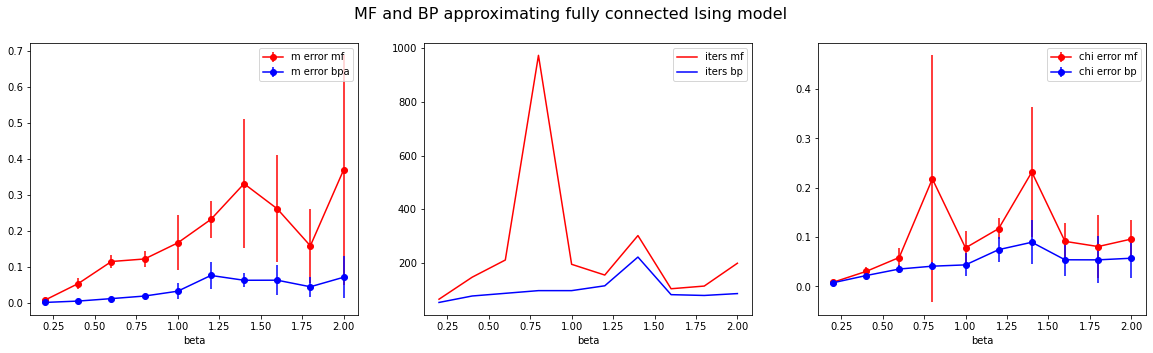

In [9]:
fig, (ax1, ax2, ax3) = plt.subplots(nrows=1, ncols=3)
fig.suptitle('MF and BP approximating fully connected Ising model', fontsize=16)
fig.set_size_inches(20, 5)
ax1.errorbar(betas, m_mfa_means, yerr=m_mfa_stds, color='r', fmt='-o', label='m error mf')
ax1.errorbar(betas, m_bpa_means, yerr=m_bpa_stds, color='b', fmt='-o', label='m error bpa')
ax1.set(xlabel='beta')
ax1.legend()
ax2.plot(betas, mfa_iter, color='r', label='iters mf')
ax2.plot(betas, bpa_iter, color='b', label='iters bp')
ax2.set(xlabel='beta')
ax2.legend()
ax3.errorbar(betas, chi_mfa_means, yerr=chi_mfa_stds, color='r', fmt='-o', label='chi error mf')
ax3.errorbar(betas, chi_bpa_means, yerr=chi_bpa_stds, color='b', fmt='-o', label='chi error bp')
ax3.set(xlabel='beta')
ax3.legend()
plt.show()

In [10]:
def ErrorsSparse(seed_index, beta, iter_times):
    '''
    Returns:
        a list of tuples [(mean of rmse of mfa, std of rmse of mfa), (mean of rmse of bpa, std of rmse of bpa)]
    '''
    i = 0
    errors_mfa = []
    errors_bpa = []
    
    chi_errors_mfa = []
    chi_errors_bpa = []
    
    #seed = np.random.randint(0, np.iinfo(np.int32).max)
    #print(seed)
    seed = seeds[i]
    np.random.seed(seed)
    
    while i < iter_times:
        m = np.random.rand(n,1)
        a = np.random.rand(n, n)
        a = a - np.diag(np.diag(a))
        th = 0.1*np.ones((n,1))
        w = sparseOrNot(False, 0.2, c)
        
        mfa = meanFieldApprox(w, th)
        mfa_results = mfa.train(0.5, m)
        m_mfa = mfa_results[0]
        chi_mfa = mfa_results[2]
        
        bpa = beliefProp(w, th)
        bpa_results = bpa.train(0.5, a)
        m_bpa = bpa_results[0]
        chi_bpa = bpa_results[3]
        
        ising_results = exactIsing(sa, w, th)
        m_ex = ising_results[1]
        chi_ex = ising_results[2]
        
        mfa_iter = mfa_results[1]
        bpa_iter = bpa_results[2]
        
        error_mfa = rmse(m_mfa, m_ex)
        error_bpa = rmse(m_bpa, m_ex)
        
        chi_error_mfa = rmse(chi_mfa, chi_ex)
        chi_error_bpa = rmse(chi_bpa, chi_ex)
        
        errors_mfa.append(error_mfa)
        errors_bpa.append(error_bpa)
        
        chi_errors_mfa.append(chi_error_mfa)
        chi_errors_bpa.append(chi_error_bpa)
        
        i += 1
    
    errors_mfa = np.array(errors_mfa)
    errors_bpa = np.array(errors_bpa)
    
    return [(np.mean(errors_mfa), np.std(errors_mfa), np.mean(chi_errors_mfa), np.std(chi_errors_mfa)),(np.mean(errors_bpa), np.std(errors_bpa), np.mean(chi_errors_bpa), np.std(chi_errors_bpa)), (mfa_iter, bpa_iter)]

In [11]:
iter_times = 5
cs = np.arange(0.1, 1.1, 0.1, dtype=float)
m_mfa_means_sparse = []
m_mfa_stds_sparse = []
m_bpa_means_sparse = []
m_bpa_stds_sparse = []
chi_mfa_means_sparse = []
chi_mfa_stds_sparse = []
chi_bpa_means_sparse = []
chi_bpa_stds_sparse = []
mfa_iter_sparse = []
bpa_iter_sparse = []
seed_index = 0

# NOTICE: the for-loop will end in 10 rounds
# IMPORTANT!!!! I notice here that the BP may not converge.
# It may happen that the complete for-loop can't be finished.
# Therefore, I decided to do a smoothing on 'a' as well, it turns out to work a bit.
# Smoothing helps a bit. But the convergence is still not gaurenteed.
# I can only fix random seeds to make sure everyone can reproduce the results.
for c in cs:
    error = ErrorsSparse(seed_index, beta, iter_times)
    print(error)
    m_mfa_means_sparse.append(error[0][0])
    m_mfa_stds_sparse.append(error[0][1])
    chi_mfa_means_sparse.append(error[0][2])
    chi_mfa_stds_sparse.append(error[0][3])
    m_bpa_means_sparse.append(error[1][0])
    m_bpa_stds_sparse.append(error[1][1])
    chi_bpa_means_sparse.append(error[1][2])
    chi_bpa_stds_sparse.append(error[1][3])
    mfa_iter_sparse.append(error[2][0])
    bpa_iter_sparse.append(error[2][1])
    seed_index += 1

[(0.0133358043970084, 0.004516805269024285, 0.02712868520059607, 0.0075383448979403364), (0.0004409125030359698, 0.00045501136540420067, 0.014805046145953663, 0.0036483258788617442), (103, 59)]
[(0.045270431830679914, 0.024673830161568076, 0.12683344442417382, 0.05713160274203277), (0.002949772698573906, 0.0014040669951258607, 0.04007888914423067, 0.008576814800394553), (164, 72)]
[(0.07005579391208483, 0.02326163212218965, 0.20103697464322115, 0.06450871211659794), (0.0037908807323581485, 0.0010718482503715495, 0.048914821781190214, 0.003936833650264792), (401, 83)]
[(0.1768466626437055, 0.04827368125662993, 0.2652276545924297, 0.2082482158936256), (0.008430211335152229, 0.002804650894412714, 0.06330120654725167, 0.009426745496449597), (760, 91)]
[(0.3542872927602619, 0.06645636146378031, 0.1580468100969426, 0.02391867362692143), (0.008488237276298143, 0.002631932439160903, 0.08929899316895913, 0.015758675425474943), (437, 105)]
[(0.4257570631822768, 0.0956249242493648, 0.219347935361

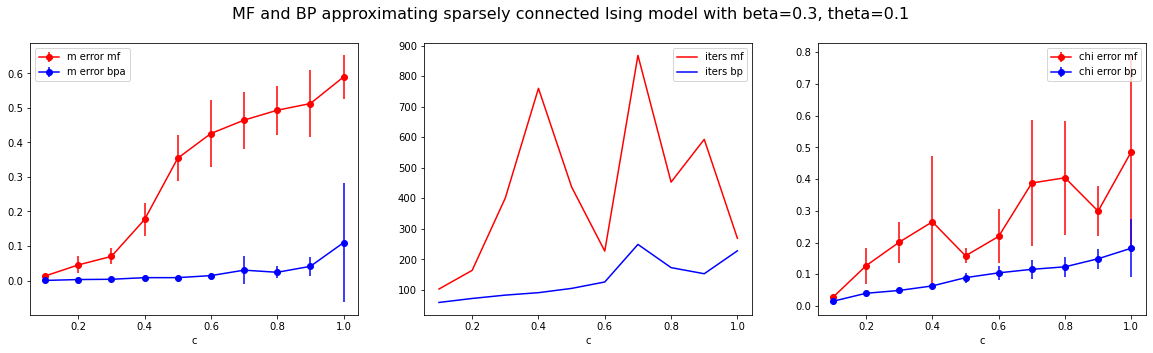

In [12]:
fig, (ax1, ax2, ax3) = plt.subplots(nrows=1, ncols=3)
fig.suptitle('MF and BP approximating sparsely connected Ising model with beta=0.3, theta=0.1', fontsize=16)
fig.set_size_inches(20, 5)
ax1.errorbar(cs, m_mfa_means_sparse, yerr=m_mfa_stds_sparse, color='r', fmt='-o', label='m error mf')
ax1.errorbar(cs, m_bpa_means_sparse, yerr=m_bpa_stds_sparse, color='b', fmt='-o', label='m error bpa')
ax1.set(xlabel='c')
ax1.legend()
ax2.plot(cs, mfa_iter_sparse, color='r', label='iters mf')
ax2.plot(cs, bpa_iter_sparse, color='b', label='iters bp')
ax2.set(xlabel='c')
ax2.legend()
ax3.errorbar(cs, chi_mfa_means_sparse, yerr=chi_mfa_stds_sparse, color='r', fmt='-o', label='chi error mf')
ax3.errorbar(cs, chi_bpa_means_sparse, yerr=chi_bpa_stds_sparse, color='b', fmt='-o', label='chi error bp')
ax3.set(xlabel='c')
ax3.legend()
plt.show()

In [13]:
def ErrorsSparse(seed_index, beta, iter_times):
    '''
    Returns:
        a list of tuples [(mean of rmse of mfa, std of rmse of mfa), (mean of rmse of bpa, std of rmse of bpa)]
    '''
    i = 0
    errors_mfa = []
    errors_bpa = []
    
    chi_errors_mfa = []
    chi_errors_bpa = []
    
    #seed = np.random.randint(0, np.iinfo(np.int32).max)
    #print(seed)
    seed = seeds[i]
    np.random.seed(seed)
    
    while i < iter_times:
        m = np.random.rand(n,1)
        a = np.random.rand(n, n)
        a = a - np.diag(np.diag(a))
        th = Jth*np.ones((n,1))
        w = sparseOrNot(False, 0.3, 0.4)
        
        mfa = meanFieldApprox(w, th)
        mfa_results = mfa.train(0.5, m)
        m_mfa = mfa_results[0]
        chi_mfa = mfa_results[2]
        
        bpa = beliefProp(w, th)
        bpa_results = bpa.train(0.5, a)
        m_bpa = bpa_results[0]
        chi_bpa = bpa_results[3]
        
        ising_results = exactIsing(sa, w, th)
        m_ex = ising_results[1]
        chi_ex = ising_results[2]
        
        mfa_iter = mfa_results[1]
        bpa_iter = bpa_results[2]
        
        error_mfa = rmse(m_mfa, m_ex)
        error_bpa = rmse(m_bpa, m_ex)
        
        chi_error_mfa = rmse(chi_mfa, chi_ex)
        chi_error_bpa = rmse(chi_bpa, chi_ex)
        
        errors_mfa.append(error_mfa)
        errors_bpa.append(error_bpa)
        
        chi_errors_mfa.append(chi_error_mfa)
        chi_errors_bpa.append(chi_error_bpa)
        
        i += 1
    
    errors_mfa = np.array(errors_mfa)
    errors_bpa = np.array(errors_bpa)
    
    return [(np.mean(errors_mfa), np.std(errors_mfa), np.mean(chi_errors_mfa), np.std(chi_errors_mfa)),(np.mean(errors_bpa), np.std(errors_bpa), np.mean(chi_errors_bpa), np.std(chi_errors_bpa)), (mfa_iter, bpa_iter)]

In [14]:
iter_times = 5
ths = np.arange(0.5, 5.1, 0.5, dtype=float)
m_mfa_means_sparse = []
m_mfa_stds_sparse = []
m_bpa_means_sparse = []
m_bpa_stds_sparse = []
chi_mfa_means_sparse = []
chi_mfa_stds_sparse = []
chi_bpa_means_sparse = []
chi_bpa_stds_sparse = []
mfa_iter_sparse = []
bpa_iter_sparse = []
seed_index = 0

# NOTICE: the for-loop will end in 10 rounds
# IMPORTANT!!!! I notice here that the BP may not converge.
# It may happen that the complete for-loop can't be finished.
# Therefore, I decided to do a smoothing on 'a' as well, it turns out to work a bit.
# Smoothing helps a bit. But the convergence is still not gaurenteed.
# I can only fix random seeds to make sure everyone can reproduce the results.
for Jth in ths:
    error = ErrorsSparse(seed_index, beta, iter_times)
    print(error)
    m_mfa_means_sparse.append(error[0][0])
    m_mfa_stds_sparse.append(error[0][1])
    chi_mfa_means_sparse.append(error[0][2])
    chi_mfa_stds_sparse.append(error[0][3])
    m_bpa_means_sparse.append(error[1][0])
    m_bpa_stds_sparse.append(error[1][1])
    chi_bpa_means_sparse.append(error[1][2])
    chi_bpa_stds_sparse.append(error[1][3])
    mfa_iter_sparse.append(error[2][0])
    bpa_iter_sparse.append(error[2][1])
    seed_index += 1

[(0.20806291251637013, 0.06066280602078144, 0.1526360575831936, 0.15488241553033982), (0.03440124388895389, 0.010183363125768955, 0.057878133357676075, 0.014823393939940074), (153, 105)]
[(0.06963209363479188, 0.021795062748105904, 0.04356934063696928, 0.03097757883555614), (0.009866380892212982, 0.004834226385345094, 0.016721627481328973, 0.00960099551169789), (98, 75)]
[(0.0267138241481083, 0.012801950957261813, 0.010988276043312182, 0.005248792591881892), (0.0024429805405595654, 0.0015323338893342788, 0.0039189327143556996, 0.0027019355487785638), (83, 62)]
[(0.009283247555976298, 0.005394720296397305, 0.0035740833841803542, 0.0018430756858056436), (0.0004444310734944707, 0.0003134991499403363, 0.0005866671580802458, 0.00042088445029067454), (65, 54)]
[(0.0027733808270226134, 0.0018499559088581306, 0.0010217969774260001, 0.000634533644649656), (4.9822270154061616e-05, 3.6623697163874914e-05, 5.6382240520882524e-05, 4.24220284384181e-05), (53, 50)]
[(0.0006021018261156122, 0.00045017

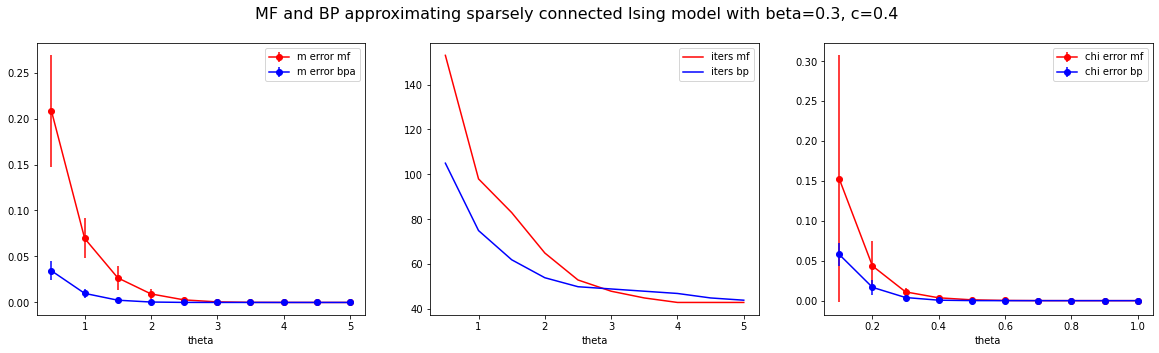

In [15]:
fig, (ax1, ax2, ax3) = plt.subplots(nrows=1, ncols=3)
fig.suptitle('MF and BP approximating sparsely connected Ising model with beta=0.3, c=0.4', fontsize=16)
fig.set_size_inches(20, 5)
ax1.errorbar(ths, m_mfa_means_sparse, yerr=m_mfa_stds_sparse, color='r', fmt='-o', label='m error mf')
ax1.errorbar(ths, m_bpa_means_sparse, yerr=m_bpa_stds_sparse, color='b', fmt='-o', label='m error bpa')
ax1.set(xlabel='theta')
ax1.legend()
ax2.plot(ths, mfa_iter_sparse, color='r', label='iters mf')
ax2.plot(ths, bpa_iter_sparse, color='b', label='iters bp')
ax2.set(xlabel='theta')
ax2.legend()
ax3.errorbar(cs, chi_mfa_means_sparse, yerr=chi_mfa_stds_sparse, color='r', fmt='-o', label='chi error mf')
ax3.errorbar(cs, chi_bpa_means_sparse, yerr=chi_bpa_stds_sparse, color='b', fmt='-o', label='chi error bp')
ax3.set(xlabel='theta')
ax3.legend()
plt.show()

In [16]:
def ErrorsSparse(seed_index, beta, iter_times):
    '''
    Returns:
        a list of tuples [(mean of rmse of mfa, std of rmse of mfa), (mean of rmse of bpa, std of rmse of bpa)]
    '''
    i = 0
    errors_mfa = []
    errors_bpa = []
    
    chi_errors_mfa = []
    chi_errors_bpa = []
    
    #seed = np.random.randint(0, np.iinfo(np.int32).max)
    #print(seed)
    seed = seeds[i]
    np.random.seed(seed)
    
    while i < iter_times:
        m = np.random.rand(n,1)
        a = np.random.rand(n, n)
        a = a - np.diag(np.diag(a))
        th = 6*np.ones((n,1))
        w = sparseOrNot(False, beta, 0.8)
        
        mfa = meanFieldApprox(w, th)
        mfa_results = mfa.train(0.5, m)
        m_mfa = mfa_results[0]
        chi_mfa = mfa_results[2]
        
        bpa = beliefProp(w, th)
        bpa_results = bpa.train(0.5, a)
        m_bpa = bpa_results[0]
        chi_bpa = bpa_results[3]
        
        ising_results = exactIsing(sa, w, th)
        m_ex = ising_results[1]
        chi_ex = ising_results[2]
        
        mfa_iter = mfa_results[1]
        bpa_iter = bpa_results[2]
        
        error_mfa = rmse(m_mfa, m_ex)
        error_bpa = rmse(m_bpa, m_ex)
        
        chi_error_mfa = rmse(chi_mfa, chi_ex)
        chi_error_bpa = rmse(chi_bpa, chi_ex)
        
        errors_mfa.append(error_mfa)
        errors_bpa.append(error_bpa)
        
        chi_errors_mfa.append(chi_error_mfa)
        chi_errors_bpa.append(chi_error_bpa)
        
        i += 1
    
    errors_mfa = np.array(errors_mfa)
    errors_bpa = np.array(errors_bpa)
    
    return [(np.mean(errors_mfa), np.std(errors_mfa), np.mean(chi_errors_mfa), np.std(chi_errors_mfa)),(np.mean(errors_bpa), np.std(errors_bpa), np.mean(chi_errors_bpa), np.std(chi_errors_bpa)), (mfa_iter, bpa_iter)]

In [17]:
iter_times = 5
betas = np.arange(0.1, 1.1, 0.1, dtype=float)
m_mfa_means_sparse = []
m_mfa_stds_sparse = []
m_bpa_means_sparse = []
m_bpa_stds_sparse = []
chi_mfa_means_sparse = []
chi_mfa_stds_sparse = []
chi_bpa_means_sparse = []
chi_bpa_stds_sparse = []
mfa_iter_sparse = []
bpa_iter_sparse = []
seed_index = 0

# NOTICE: the for-loop will end in 10 rounds
# IMPORTANT!!!! I notice here that the BP may not converge.
# It may happen that the complete for-loop can't be finished.
# Therefore, I decided to do a smoothing on 'a' as well, it turns out to work a bit.
# Smoothing helps a bit. But the convergence is still not gaurenteed.
# I can only fix random seeds to make sure everyone can reproduce the results.
for beta in betas:
    error = ErrorsSparse(seed_index, beta, iter_times)
    print(error)
    m_mfa_means_sparse.append(error[0][0])
    m_mfa_stds_sparse.append(error[0][1])
    chi_mfa_means_sparse.append(error[0][2])
    chi_mfa_stds_sparse.append(error[0][3])
    m_bpa_means_sparse.append(error[1][0])
    m_bpa_stds_sparse.append(error[1][1])
    chi_bpa_means_sparse.append(error[1][2])
    chi_bpa_stds_sparse.append(error[1][3])
    mfa_iter_sparse.append(error[2][0])
    bpa_iter_sparse.append(error[2][1])
    seed_index += 1

[(1.2449077924325683e-10, 4.0202145074701064e-11, 5.824080325133943e-11, 1.866424095959399e-11), (3.1263607994841757e-15, 1.2031366454954327e-15, 5.33475240157599e-15, 2.7656484670132063e-15), (43, 44)]
[(1.68915276413275e-09, 1.0021437158852128e-09, 8.21648929936945e-10, 4.942202454854814e-10), (2.8382767744603062e-14, 1.8842190154280656e-14, 3.7498948651679563e-14, 2.3981813698581916e-14), (43, 44)]
[(2.1533708318558972e-08, 1.978258183493082e-08, 1.1059734323259119e-08, 1.0404200119053182e-08), (1.2339643428098624e-12, 1.2098313480719336e-12, 1.2575060952604741e-12, 1.1805946536051944e-12), (43, 44)]
[(2.9491018093907526e-07, 3.60440305367377e-07, 1.5900360860315265e-07, 1.968880512831347e-07), (5.158842248689394e-11, 5.64944447694737e-11, 4.6085302860848125e-11, 4.7794087670853756e-11), (43, 44)]
[(4.177745507169301e-06, 6.0220851801782474e-06, 2.3106064197413915e-06, 3.3306868319768733e-06), (2.0062625714504977e-09, 2.4308688379130218e-09, 1.6427512331209188e-09, 1.852060558334264

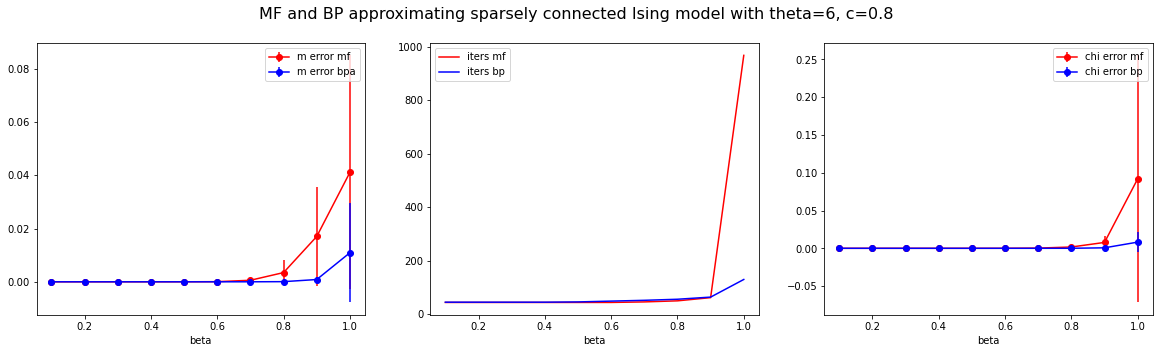

In [18]:
fig, (ax1, ax2, ax3) = plt.subplots(nrows=1, ncols=3)
fig.suptitle('MF and BP approximating sparsely connected Ising model with theta=6, c=0.8', fontsize=16)
fig.set_size_inches(20, 5)
ax1.errorbar(betas, m_mfa_means_sparse, yerr=m_mfa_stds_sparse, color='r', fmt='-o', label='m error mf')
ax1.errorbar(betas, m_bpa_means_sparse, yerr=m_bpa_stds_sparse, color='b', fmt='-o', label='m error bpa')
ax1.set(xlabel='beta')
ax1.legend()
ax2.plot(betas, mfa_iter_sparse, color='r', label='iters mf')
ax2.plot(betas, bpa_iter_sparse, color='b', label='iters bp')
ax2.set(xlabel='beta')
ax2.legend()
ax3.errorbar(betas, chi_mfa_means_sparse, yerr=chi_mfa_stds_sparse, color='r', fmt='-o', label='chi error mf')
ax3.errorbar(betas, chi_bpa_means_sparse, yerr=chi_bpa_stds_sparse, color='b', fmt='-o', label='chi error bp')
ax3.set(xlabel='beta')
ax3.legend()
plt.show()